<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/07_machine_learning_intro/07_workalong01_machine_learning_basics.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Machine Learning Basics

This workalong walks through some of the basic elements of modern machine learning, including *rectified linear units (reLU)*, *loss functions*, *backpropagation*, and the use of `pytorch`.

## Rectified linear units (reLU)

In the cell below, implement two functions:
 1. `linear(x,w,b)`
 2. `relu(x)`

as indicated in the functions' docstrings.  (Note, remove the lines with `pass` - this is just a line of code that says to Python "do nothing"...it's necessary because function's can't be empty in Python.)

Test that it works as expected, and keep your tests in the notebook.

In [27]:
""" Define a linear and relu function. """
import numpy as np

def linear(x : np.ndarray, w : float = 1, b : float = 0) -> np.ndarray:
    """ returns w*x + b """
    return w*x + b

def relu(x : np.ndarray) -> np.ndarray:
    """ returns x if x is positive, 0 otherwise"""
    return np.maximum(0,x)

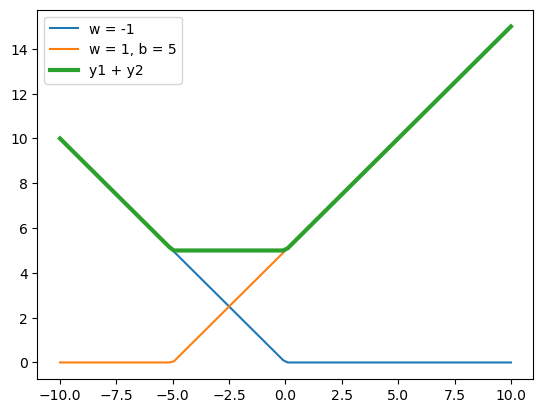

In [28]:
""" Test the relu function. """

x = np.linspace(-10,10,100)
y1 = relu(linear(x, w = -1, b= 0))
y2 = relu(linear(x, w = 1, b= 5))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(x,y1, label = "w = -1")
ax.plot(x,y2, label = "w = 1, b = 5")
ax.plot(x,y1+y2, label = "y1 + y2", linewidth = 3)
ax.legend()

plt.show()

## Fitting a function with reLUs

1. Run the cell below to create a graph of fake, noisy data (variable `noisy_data`).
1. In the cell below that, create a function `relu_sum` that is the sum of two reLUs with a bias (a scalar) added at the end
1. Create a new plot that includes the function output and the noisy data
1. Adjust the `w` and `b` parameters until the function approximates the fake data.
1. Comment in a markdown cell on your observations, what you learned, etc.



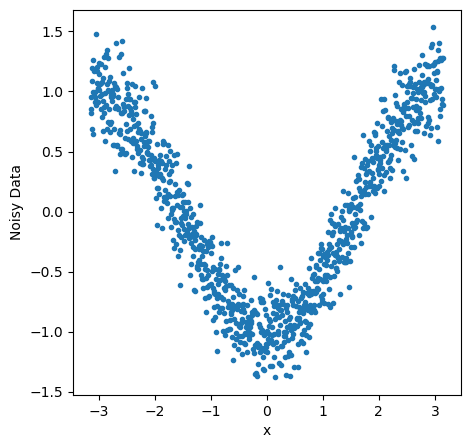

In [29]:
""" Create a fake, noisy dataset. """

# define the x values
x = np.linspace(-np.pi, np.pi, 1000)

# define the y values of the true function
y_true = -np.cos(x)

# add some noise to the true function
np.random.seed(5984)
noisy_data = y_true + np.random.normal(0, 0.2, len(x))

# plot the noisy data
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(x, noisy_data, '.', label="data")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
plt.show()

In [30]:
""" Define a function that is the sum of two relus. """

def relu_sum(x : np.ndarray, w : np.ndarray, b : np.ndarray, bias : float = 0) -> np.ndarray:
    """ returns relu(w[0]*x + b[0]) + relu(w[1]*x + b[1]) + bias """
    return relu(linear(x, w = w[0], b= b[0])) + relu(linear(x, w = w[1], b= b[1])) + bias





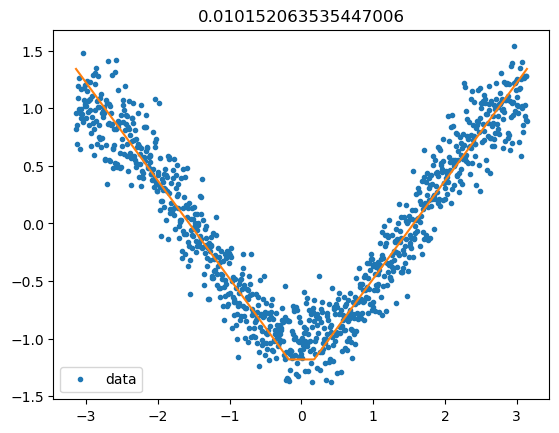

In [31]:
""" Plot the sum of two relus, with w, b such that the function fits the data. """
x = np.linspace(-np.pi, np.pi, 1000)
y = relu_sum(x = x, w = (-0.85,0.85), b = (0.15,0.15), bias=-1.48)

fig, ax = plt.subplots()

ax.plot(x, noisy_data, '.', label="data")
ax.plot(x,y)
ax.legend()
ax.set_title(f"{loss(y_true,y)}")

plt.show()

## Loss function

Now define a *loss* function $\mathcal{L}$: in this case *mean-squared error (MSE)* for the fit $\hat{\mathbf{z}}$ relative to the data $\mathbf{z}$

$$ \mathcal{L} = \frac{1}{N} \sum\limits_{i=0}^{N-1} (z_i - \hat{z}_i)^2$$

Calculate the loss for your fit to the data above: we'll compare in class.

In [32]:
""" Define a loss function. """

def loss(y_true : np.ndarray, y_pred : np.ndarray) -> float:
    """ returns the mean squared error between y_true and y_pred """
    return np.square(y_true-y_pred).mean()

# calculate the loss for the fit


Add the loss to the title of the plot, and vary the parameters further to see if you can minimize the loss.

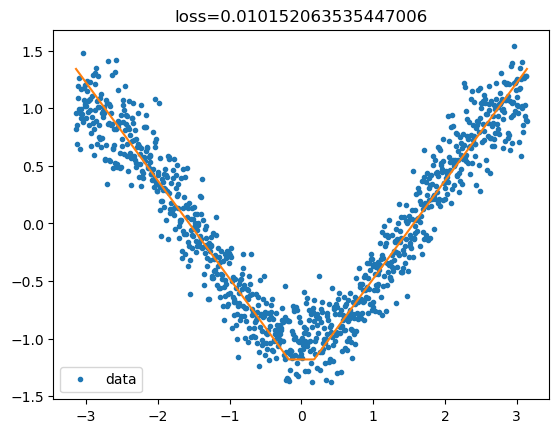

In [46]:
""" Vary parameters, minimizing the loss (include loss in title). """
x = np.linspace(-np.pi, np.pi, 1000)
y = relu_sum(x = x, w = (-0.85,0.85), b = (0.15,0.15), bias=-1.48)

fig, ax = plt.subplots()

ax.plot(x, noisy_data, '.', label="data")
ax.plot(x,y)
ax.legend()
ax.set_title(f"loss={loss(y_true,y)}")

plt.show()


In [34]:
loss(y_true,y)

0.010152063535447006

## ReLUs in `pytorch`

Now we'll take advantage of `pytorch` for automating the process of fitting a NN model.

In [43]:
""" Define a neural network with a single hidden layer. """
# import pytorch
import torch
import torch.nn as nn
# set the random seed for reproducibility
torch.manual_seed(5984)

class Net(nn.Module):
    def __init__(self, n_relus: int = 2):
        super().__init__()

        
        self.linear_reul_stack = nn.Sequential(
            nn.Linear(1, n_relus), # Layer 1
            nn.ReLU(),             # Layer 2
            nn.Linear(n_relus,1),  # Layer 3
        )

    def forward(self, x):
        """ Define forward model """
        out = self.linear_reul_stack(x)
        return out

In [45]:
test_net = Net()

xx = torch.tensor([3.])
test_net(xx)

tensor([0.4319], grad_fn=<AddBackward0>)

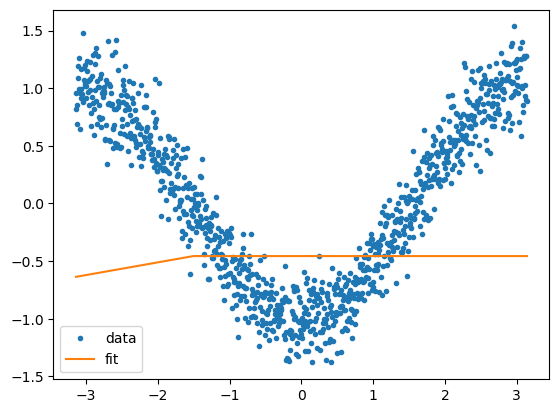

In [53]:
""" Show the initial model prediction/fit (it's bad)"""
# convert x, y to torch tensor
xt = torch.from_numpy(x).unsqueeze(1).to(torch.float32)
yt = torch.from_numpy(noisy_data).unsqueeze(1).to(torch.float32)

model_2 = Net(n_relus=2)
pred = model_2(xt)


fig, ax = plt.subplots()

ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, pred.detach().numpy(), label="fit")
ax.legend()

plt.show()

### Training the model - the simple, but not-so-great way

We'll use a simple for loop to train the model on all the data.  This is bad because we don't split the dataset into train, test, and validation sets; this can make our efforts prone to overfitting.

But for simplicity, we'll forge forward with this (inadvisable) approach.

In [54]:
""" Train the model the bad way. """
# set hyperparameters

learning_rate = 0.01
training_steps = 1000
num_relus = 2

# define the model
torch.manual_seed(5984)
model_2 = Net(n_relus= num_relus)

# define loss
loss_fn = nn.MSELoss()

# define optimized
optim = torch.optim.Adam(model_2.parameters(), lr = learning_rate)

# Training loop
for n in range(training_steps):
    # calculate the prediction
    pred = model_2(xt)

    # claculate the loss
    loss = loss_fn(pred, yt)

    # reset the gradients
    optim.zero_grad()

    # calculate the gradients of the parameters wrt anf loss
    loss.backward()

    # updata parameter
    optim.step()

    # print the lost every 100 steps
    if n % 100 == 0 :
        print(f"Step {n}: {loss.item():.3f}")
        

Step 0: 0.837
Step 100: 0.223
Step 200: 0.046
Step 300: 0.045
Step 400: 0.045
Step 500: 0.045
Step 600: 0.045
Step 700: 0.045
Step 800: 0.045
Step 900: 0.045


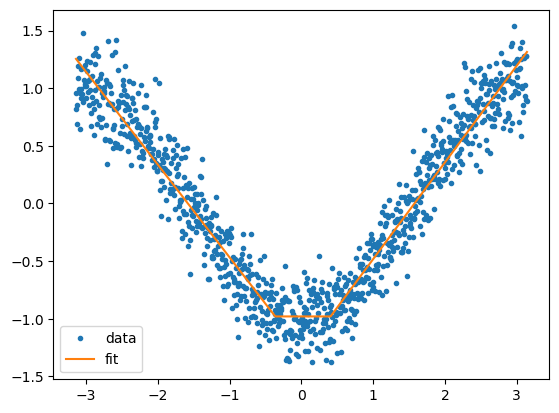

In [55]:
""" Plot the trained model. """
fig, ax = plt.subplots()

ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, pred.detach().numpy(), label="fit")
ax.legend()

plt.show()

### Training the model - the better, but more complicated way

We'll follow standard practice here to split the data into test, train and validation sets.  We'll also use pytorch's data loader to do training in batches, and we'll put our training loop into a function.  This will allow us to train in *epochs* (passes through the entire dataset).

In [39]:
""" Train the model the better, but more complicated way. """



' Train the model the better, but more complicated way. '

In [40]:
""" Plot the prediction """


' Plot the prediction '